In [1]:
from sbibm.utils.io import get_tensor_from_csv
import pandas as pd
import altair as alt
from scipy.stats import binom

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from sbi.utils import pairplot
import sbibm
import pickle
import matplotlib
from scipy.stats import gaussian_kde

# matplotlib.rcParams.update({'figure.autolayout': True})
plt.style.use('../../.matplotlibrc')

# set KDE values
num_bins = 100
bw_method = 0.3

# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
import warnings
warnings.filterwarnings('ignore')

# Select data

In [2]:
path_poisson_samples = "../../../results/benchmark_poisson_glm_snpe_samples/"
path_poisson_benchmark = "../../../results/benchmark_poisson_glm_SABC_SNPE.p"
path_sbc_fullmodel = "../../../results/sbc_results_npe_ss50_N1006.p"
path_ppc_fullmodel = "../../../results/posterior_predictive_npe_ss50_ths_xs.p"

In [3]:
task = sbibm.get_task("poisson_glm")
obs = 5
ths_ref = task.get_reference_posterior_samples(obs)
tho = task.get_true_parameters(obs)
xo = task.get_observation(obs)
ths_prior = task.get_prior_dist().sample((1000,))

ths = get_tensor_from_csv(path_poisson_samples + "posterior_samples.csv.bz2")
xs = get_tensor_from_csv(path_poisson_samples + "predictive_samples.csv.bz2")

# SBC results full model
with open(path_sbc_fullmodel, "rb") as fh:
    N2, ranks2, L2, *_ = pickle.load(fh).values()
    
# Benchmark results:
# NOTE: Choose result based on prior!
with open(path_poisson_benchmark, "rb") as fh:
    df, means, stds, benchmark_labels, num_simulations, num_observations = pickle.load(fh).values()
    
# PPCs full model
with open(path_ppc_fullmodel, "rb") as fh:
    prior, posterior, tho2, xo2, ths2, xs2, ths_prior2, xs_prior2, xos2 = pickle.load(fh).values()
# tho2[0, -1] *= -1 
ths2 = posterior.sample((ths.shape[0],), x=xo2)
means = means.squeeze()
stds = stds.squeeze()

# ths2[:, 2] *= -1

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [4]:
def plot_sbc(ranks, num_bins, alpha=.8, num_ticks=3, color="C0", 
             ranks_label=None, num_repeats=50, show_ylabel=True, 
             show_legend=False, xlabel=None, plot_uniform_region=False,
             legend_kwargs={},
            ):
    
    # Generate histogram of ranks.
    hist, *_ = np.histogram(ranks, bins=num_bins, density=False)
    # Construct empirical CDF.
    histcs = hist.cumsum()
    # Plot cdf and repeat each stair step
    plt.plot(
        np.linspace(0, num_bins, num_repeats * num_bins),
        np.repeat(histcs / histcs.max(), num_repeats),
        label=ranks_label,
        color=color,
        alpha=alpha,
    )

    if show_ylabel:
        plt.yticks(np.linspace(0, 1, 3))
        plt.ylabel("empirical CDF")
    else:
        # Plot ticks only
        plt.yticks(np.linspace(0, 1, 3), [])
    if show_legend and ranks_label:
        plt.legend(loc=2, handlelength=1.0, **legend_kwargs)

    plt.ylim(0, 1)
    plt.xlim(0, num_bins)
    plt.xticks(np.linspace(0, num_bins, num_ticks))
    plt.xlabel("posterior rank" if xlabel is None else xlabel)
    
    if plot_uniform_region:
        # Construct uniform histogram.
        num_sbc_runs = ranks.shape[0]
        uni_bins = binom(num_sbc_runs, p=1 / num_bins).ppf(0.5) * np.ones(num_bins)
        uni_bins_cdf = uni_bins.cumsum() / uni_bins.sum()
        # Decrease value one in last entry by epsilon to find valid
        # confidence intervals.
        uni_bins_cdf[-1] -= 1e-9

        lower = [binom(num_sbc_runs, p=p).ppf(0.005) for p in uni_bins_cdf]
        upper = [binom(num_sbc_runs, p=p).ppf(0.995) for p in uni_bins_cdf]

        # Plot grey area with expected ECDF.
        plt.fill_between(
            x=np.linspace(0, num_bins, num_repeats * num_bins),
            y1=np.repeat(lower / np.max(lower), num_repeats),
            y2=np.repeat(upper / np.max(upper), num_repeats),
            color="grey",
            alpha=0.2,
        )

def plot_benchmark(ax):
    plt.sca(ax)
    nlines = means.shape[0]
    idxs = [2, 0, 3]
#     NPE, REJ, SMC, SNPE
#     idxs = [3, 0, 2, 1]
    
    cs = [colors[1], "grey", "k", colors[0]]
    alphas = [.8, 0.5, 0.5, .8]
    for i in idxs:
        plt.errorbar(num_simulations, 
                     y=means[i, ], marker='o',
                     yerr=stds[i,:] / np.sqrt(num_observations), 
                     color=cs[i], 
                     alpha=alphas[i],)

    plt.xscale("log")
    plt.yticks(np.linspace(.5, 1, 3))
    # plt.grid(axis='y')
    plt.legend([benchmark_labels[j] for j in idxs], frameon=False);
    plt.ylabel("C2ST")
    plt.xlabel("Number of simulations");


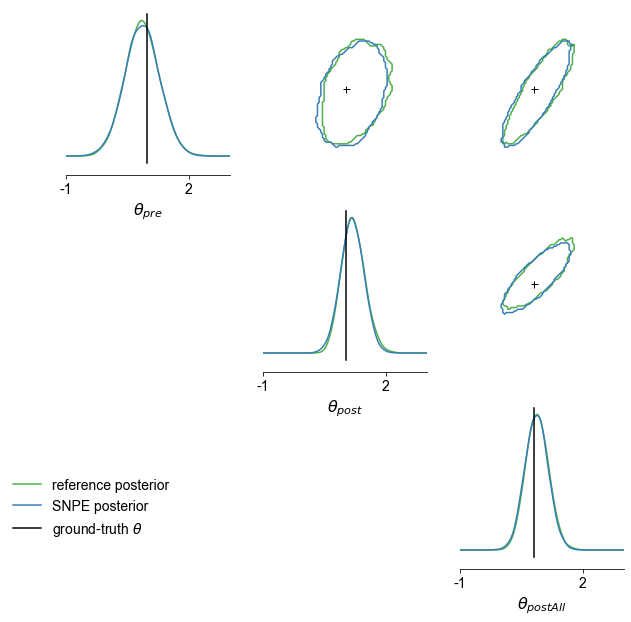

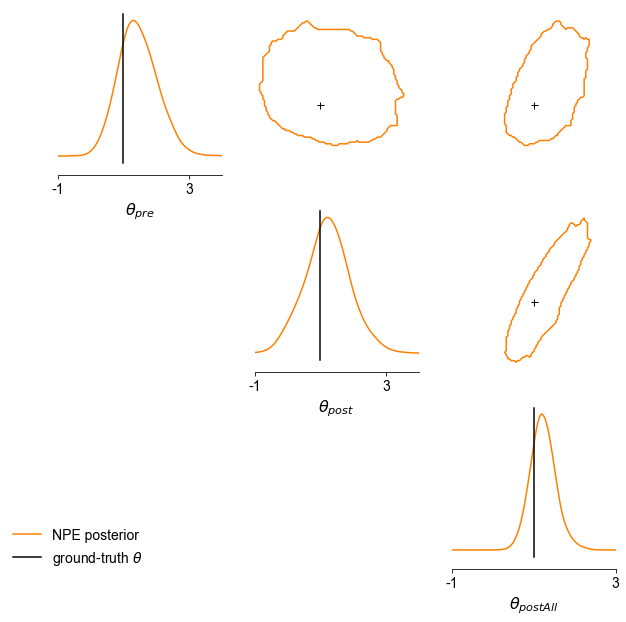

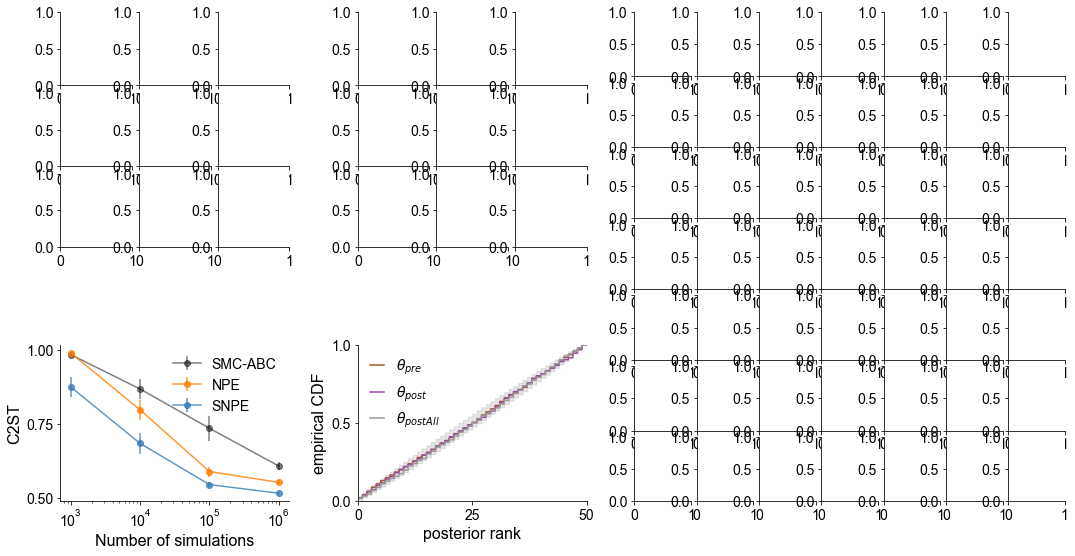

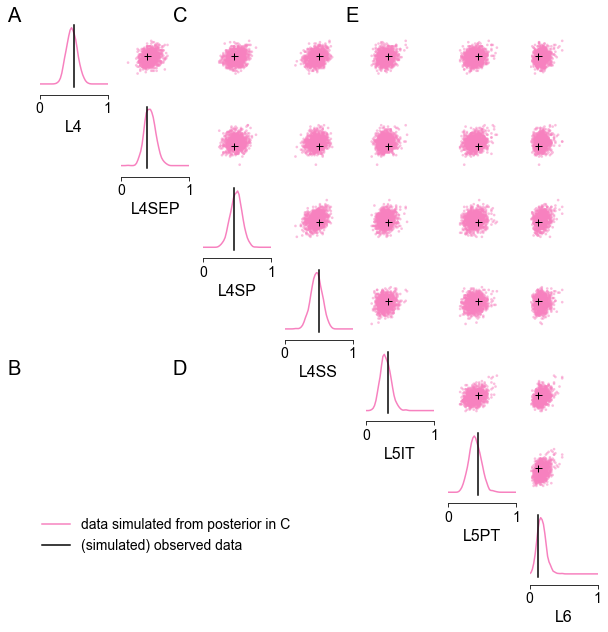

In [5]:
fig = plt.figure(figsize=(18, 9))
super_grid = fig.add_gridspec(1, 2, wspace=0.1, hspace=0, width_ratios=[.55, .45])
height_ratios = [0.6, .4]
num_data = 7
num_params = 3
# plot fewer samples for debugging
num_samples = 10000
num_bins = 100
bw_method = 0.25

# posteriors 
left_grid = super_grid[0, 0].subgridspec(2, 1, hspace=.5, height_ratios=height_ratios)
posterior_grid = left_grid[0, 0].subgridspec(1, 2, wspace=0.3,)
posterior_axs = posterior_grid.subplots()
posterior_axs[0].set_axis_off()
posterior_axs[1].set_axis_off()

# posterior grids
grid1 = posterior_grid[0].subgridspec(num_params, num_params, wspace=0.1, hspace=0.1)
ax1 = grid1.subplots()


grid1 = posterior_grid[1].subgridspec(num_params, num_params, wspace=0.1, hspace=0.1)
ax2 = grid1.subplots()

# ppc grid
grid3 = super_grid[0, 1].subgridspec(num_data, num_data, wspace=0.1, hspace=.1)
ax3 = grid3.subplots()

# benchmark plot
benchmark_grid = left_grid[1, 0].subgridspec(1, 2, wspace=0.3)
benchmark_axs = benchmark_grid.subplots()
ax4 = benchmark_axs[0]
ax5 = benchmark_axs[1]

param_labels = [r"$\theta_{pre}$", r"$\theta_{post}$", r"$\theta_{postAll}$"]
data_labels = [r"L4", r"L4SEP", r"L4SP", r"L4SS", r"L5IT", r"L5PT", r"L6"]
plt.style.use("../../.matplotlibrc")

# Posteriors
posterior_opts = dict(upper="contour", 
                      diag="kde",
                      contour_offdiag=dict(levels=[0.99]), 
                      points_colors=["k"],
                      points_offdiag=dict(marker="+", markersize=7), 
                      kde_offdiag=dict(bins=num_bins, bw_method=bw_method),
                      kde_diag=dict(bins=num_bins, bw_method=bw_method),
                      labels = param_labels,

           )
fig, ax1 = pairplot([ths_ref[:num_samples], ths[:num_samples]], 
                    points=tho.squeeze(), samples_colors=[colors[2], colors[0]],
                    fig=fig, axes=ax1, 
                    limits=[[-1, 3], [-1, 3], [-1, 3]], 
                    ticks =[[-1, 2]] * 3,
                    **posterior_opts)

plt.sca(ax1[0, 0])
plt.legend(["reference posterior", "SNPE posterior", r"ground-truth $\theta$"], 
           bbox_to_anchor=(-.4, -1.8), 
           loc=2)

# posterior_opts.update(upper="kde")
fig, ax2 = pairplot([ths2[:num_samples]], points=tho2.squeeze(), 
                    samples_colors=[colors[1]],
                    fig=fig, axes=ax2,
                    limits=[[-1, 4], [-1, 4], [-1, 3]], 
                    ticks =[[-1, 3]] * 3,
                    **posterior_opts)    
plt.sca(ax2[0, 0])
plt.legend(["NPE posterior", r"ground-truth $\theta$"], 
           bbox_to_anchor=(-.35, -2.1), 
           loc=2)

# Benchmark
plot_benchmark(ax4)
num_bins = 50
for idx, r in enumerate(ranks2):
    plt.sca(ax5)
    plot_sbc(np.array(r), num_bins=num_bins, 
             show_ylabel=True, color=colors[idx+4], 
             alpha=1.0,
             show_legend=idx==2, 
             ranks_label=param_labels[idx],
             plot_uniform_region=idx==2,
            )

fig, ax3 = pairplot(xs2[:num_samples], points=xo2.squeeze(), limits=[[0, 1]]*7, 
                    labels=data_labels, 
                    hist_diag = dict(bins=10),
                    points_offdiag=posterior_opts["points_offdiag"],
                    points_colors=["k"],
                    upper="scatter",
                    diag="kde",
                    scatter_offdiag=dict(s=7, alpha=0.5),
                    contour_offdiag=dict(levels=[0.99]),
                      kde_offdiag=dict(bins=num_bins, bw_method=bw_method),
                      kde_diag=dict(bins=num_bins, bw_method=bw_method),                    
                    samples_colors=[colors[3]],
                    axes=ax3, 
                    fig=fig,
                   )
plt.sca(ax3[0, 0])
plt.legend(["data simulated from posterior in C", "(simulated) observed data"], 
           bbox_to_anchor=(-.15, -6.1), 
           loc=2)

# Add Letters.
weight = "regular"
fontsize = 20
x = 0.08
dx1 = 0.31
dx2 = 0.55
y = 0.9
dy = 0.41
fig.text(x, y, "A", fontsize=fontsize, fontweight=weight)
fig.text(dx1, y, "C", fontsize=fontsize, fontweight=weight)
fig.text(dx2, y, "E", fontsize=fontsize, fontweight=weight)

fig.text(x, dy, "B", fontsize=fontsize, fontweight=weight)
fig.text(dx1, dy, "D", fontsize=fontsize, fontweight=weight)
plt.tight_layout();

In [6]:
fig.savefig("../fig/fig1.png", dpi=300, bbox_inches='tight')
fig.savefig("../fig/fig1.pdf", dpi=300, bbox_inches='tight')
fig.savefig("../fig/fig1.svg", dpi=300, bbox_inches='tight')